<a href="https://colab.research.google.com/github/juhiishah/CNN-on-Real-Images/blob/main/CNN_on_real_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Standard Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Define transforms

In [ ]:
train_transform = transforms.Compose([
                  transforms.RandomRotation(10),
                  transforms.RandomHorizontalFlip(),
                  transforms.Resize(224),
                  transforms.CenterCrop(224),
                  transforms.ToTensor(),
                  transforms.Normalize([0.485, 0.456, 0.406],
                                       [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
                 transforms.Resize(224),
                 transforms.CenterCrop(224),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406],
                                      [0.229, 0.224, 0.225]) 
])

In [ ]:
# Prepare Train and Test sets, loaders

In [ ]:
root = '/content/drive/MyDrive/Deep Learning Data/CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)

In [ ]:
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

In [ ]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10,shuffle=True)
test_loader = DataLoader(test_data, batch_size=10,shuffle=True)

In [ ]:
class_names = train_data.classes
print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available: {len(test_data)}')

['CAT', 'DOG']
Training images available: 18743
Testing images available: 6251


In [ ]:
# Grab a batch of the first 10 images from the training data

for images,labels in train_loader:
  break

In [ ]:
images.shape   # 10images, 3 color channel, 224by224

torch.Size([10, 3, 224, 224])

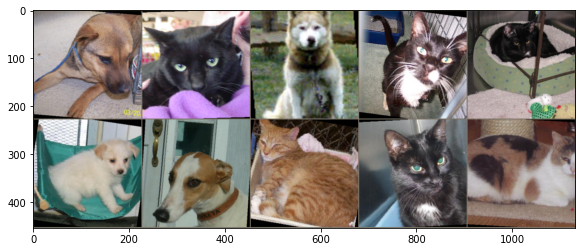

In [ ]:
im = make_grid(images, nrow=5)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

im_inv = inv_normalize(im)

plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))

In [ ]:
# Define the model


In [ ]:
class ConvolutionalNetwork(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.fc1 = nn.Linear(54*54*16,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,2)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    X = X.view(-1, 54*54*16)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)


In [ ]:
#size of image - lack of padding / pooling layer

#Why (54x54x16)?
#With 224 pixels per side, the kernels and pooling layers result in
#(((224−2)/2)−2)/2=54.5  which rounds down to 54 pixels per side.

In [ ]:
# Define Loss Function and optimizer
torch.manual_seed(42)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [ ]:
# Looking at the trainable parameters

def count_parameters(model):
  params = [p.numel() for p in model.parameters() if p.requires_grad]
  for item in params:
    print(f'{item:>8}')
  print(f'_________\n{sum(params):>8}')

In [ ]:
count_parameters(CNNmodel)

     162
       6
     864
      16
 5598720
     120
   10080
      84
     168
       2
_________
 5610222


In [ ]:
# Train the Model

In [ ]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.47453675  accuracy:  71.600%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.51732415  accuracy:  71.300%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.48195681  accuracy:  72.017%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.46371087  accuracy:  72.463%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.56808358  accuracy:  72.750%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.40674028  accuracy:  73.725%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.41786200  accuracy:  73.933%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.47432446  accuracy:  74.463%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.58575374  accuracy:  76.800%
epoch:  2  batch:  400 [  4000/8000]  loss: 0.80670369  accuracy:  76.550%
epoch:  2  batch:  600 [  6000/8000]  loss: 0.33195642  accuracy:  76.517%
epoch:  2  batch:  800 [  8000/8000]  loss: 0.21846016  accuracy:  76.325%

Duration: 4632 seconds


In [ ]:
# Save the train model

In [ ]:
torch.save(CNNmodel.state_dict(), 'CustomImageCNNModel.pt')

In [ ]:
# Evaluate model performance

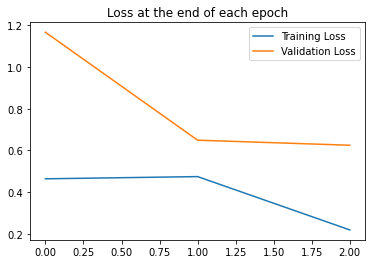

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss at the end of each epoch')
plt.legend();

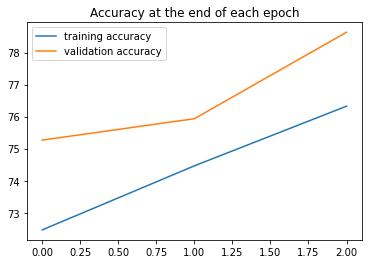

In [ ]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [ ]:
# Download a pretrained model


In [ ]:
AlexNetModel = models.alexnet(pretrained=True)
AlexNetModel

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Freeze feature parameters
# We want to freeze the pre-trained weights & biases.
# We set .requires_grad to False so we don't backprop them.

In [ ]:
for param in AlexNetModel.parameters():
  param.require_grad = False

In [ ]:
# Modify the classifier

torch.manual_seed(42)
AlexNetModel.classifier = nn.Sequential(nn.Linear(9216,1024),
                                        nn.ReLU(),
                                        nn.Linear(1024,2),
                                        nn.LogSoftmax(dim=1))

AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_featu

In [ ]:
count_parameters(AlexNetModel)

   23232
      64
  307200
     192
  663552
     384
  884736
     256
  589824
     256
 9437184
    1024
    2048
       2
_________
11909954


In [ ]:
# Define loss function & optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetModel.classifier.parameters(), lr=0.001)

In [ ]:
# Train the model

In [ ]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetModel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetModel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.09255753  accuracy:  90.450%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.67113483  accuracy:  92.200%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.49936843  accuracy:  92.767%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.02692496  accuracy:  93.425%

Duration: 1239 seconds


In [ ]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2862)]
Test accuracy: 95.400%


In [ ]:
#Run a new image through the model
#We can also pass a single image through the model to obtain a prediction.
#Pick a number from 0 to 6250, assign it to "x",
# and we'll use that value to select an image from the Cats and Dogs test set.

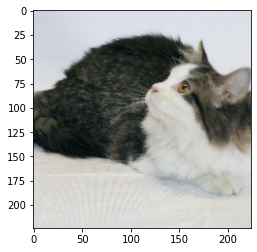

In [ ]:
x = 2019
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
test_data[x][0].shape

torch.Size([3, 224, 224])

In [ ]:
# CNN Model Prediction:

CNNmodel.eval()
with torch.no_grad():
    new_pred = CNNmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT


In [ ]:
# AlexNet Model Prediction:

AlexNetModel.eval()
with torch.no_grad():
    new_pred = AlexNetModel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT
